# Example: looking at DPC data

Start tdmq polystore:
```
 wget -O docker/docker-compose.base.yml https://raw.githubusercontent.com/tdm-project/tdm-polystore/develop/docker/docker-compose.base.yml
 wget -O docker/settings.conf https://raw.githubusercontent.com/tdm-project/tdm-polystore/develop/docker/settings.conf
 docker-compose -f docker/docker-compose.base.yml up -d
```

Ingest data.  We'll grab temperature data from the DPC for last 12 hours.
```
docker run --rm --network docker_tdmq tdmproject/dpc_ingestor \
    temperature \
    "http://web:8000/api/v0.0/" "$(sed -n -e '/TDMQ_AUTH_TOKEN/s/.*=//p' docker/settings.conf)"  ingest --strictly-after $(date -d '12 hour ago' --iso-8601=minutes --utc)
```

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
import numpy as np
from datetime import datetime, timedelta, timezone
from tdmq.client import Client

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
c = Client()

In [4]:
srcs = c.find_sources({'id': "dpc/meteo-mosaic/v0/temperature"})
assert len(srcs) > 0
s = srcs[0]

INFO:tdmq.client.client:Configured TileDB context
INFO:tdmq.client.client:Client connected to TDMQ service at http://web:8000/api/v0.0


In [5]:
start = datetime.now(tz=timezone.utc) - timedelta(hours=4)

In [6]:
ts = s.timeseries(after=start)

In [7]:
len(ts)

3

In [8]:
(time, data) = ts[0]

In [9]:
temp = data['TEMP'] * (data['TEMP'] > -9000.0)

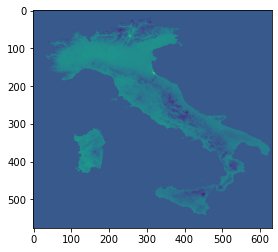

In [10]:
plt.imshow(temp)

In [11]:
(_, sardinia) = ts[0, 300:440, 100:200]

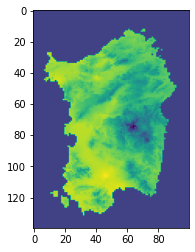

In [12]:
plt.imshow(sardinia['TEMP'] * (sardinia['TEMP'] > -9000.0))

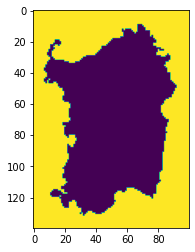

In [13]:
sea = sardinia['TEMP'] == 0
plt.imshow(sea)

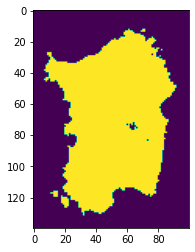

In [14]:
land = sardinia['TEMP'] > 0
plt.imshow(land)

In [15]:
(time, data) = ts[:, 300:440, 100:200]

In [16]:
temp = data['TEMP'] * (data['TEMP'] > -9000)

In [17]:
max_temp = temp.reshape(len(time), -1).max(axis=1)
min_temp = (temp + 200 * (temp == 0.0)).reshape(len(time), -1).min(axis=1)

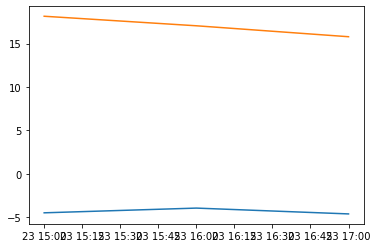

In [18]:
plt.plot(time, np.stack([min_temp, max_temp], axis=1))

In [19]:
good_frames_selector = temp.reshape(len(time), -1).max(axis=1) > 0

In [20]:
good_time = time[good_frames_selector]
good_temp = temp[good_frames_selector]

In [21]:
max_temp = good_temp.reshape(len(good_time), -1).max(axis=1)
min_temp = (good_temp + 200 * (good_temp == 0.0)).reshape(len(good_time), -1).min(axis=1)

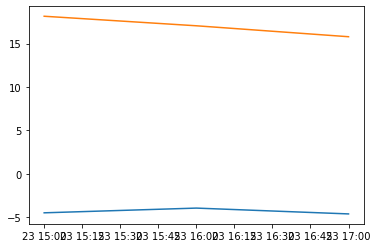

In [22]:
plt.plot(good_time, np.stack([min_temp, max_temp], axis=1))